<a href="https://colab.research.google.com/github/avcmunoz/PROYECTO_DS_ALICE_C/blob/main/ProyectoFinal_DataScienceII_Movies_Alice_Castellanos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [162]:
# Se realizan todas las importaciones necesarias
import requests
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import shap

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, RocCurveDisplay, precision_recall_curve
from wordcloud import WordCloud
from scipy.stats import randint
#from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve

# Configuración
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted")


#Se accesa con la llave generada a las API del database
API_KEY = '5676d1edf4bf885b5c694dc379d6e786'
BASE_URL = 'https://api.themoviedb.org/3'
headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json;charset=utf-8"
}

In [163]:
#Se define la sentencia para extraer los datos de las peliculas
def get_movies_by_year(year, pages=5):
    all_movies = []
    for page in range(1, pages+1):
        url = f"{BASE_URL}/discover/movie"
        params = {
            "api_key": API_KEY,
            "primary_release_year": year,
            "language": "en-US",
            "sort_by": "popularity.desc",
            "page": page
        }
        response = requests.get(url, params=params)
        if response.status_code != 200:
            print("Error en la API:", response.status_code)
            break
        data = response.json()
        all_movies.extend(data['results'])
        time.sleep(0.2)  # Para no ser bloqueado
    return all_movies


In [164]:
#Se define la sentencia para extraer detalles de las peliculas
def get_movie_details(movie_id):
    url = f"{BASE_URL}/movie/{movie_id}"
    params = {
        "api_key": API_KEY,
        "language": "en-US"
    }
    response = requests.get(url, params=params)
    if response.status_code != 200:
        return None
    return response.json()


In [165]:
#Se extraen los datos entre el rango de 2010-2025 (llega hasta 2024)
all_data = []
for year in range(2010, 2025):
    print(f"Extrayendo películas de {year}")
    movies = get_movies_by_year(year, pages=2)
    for movie in movies:
        details = get_movie_details(movie['id'])
        if details:
            all_data.append({
                "id": details['id'],
                "title": details['title'],
                "release_date": details['release_date'],
                "budget": details['budget'],
                "revenue": details['revenue'],
                "runtime": details['runtime'],
                "vote_average": details['vote_average'],
                "vote_count": details['vote_count'],
                "genres": [g['name'] for g in details['genres']],
                "popularity": details['popularity'],
                "original_language": details['original_language']
            })
    time.sleep(1)

    #para ver data:
    # all_data


Extrayendo películas de 2010
Extrayendo películas de 2011
Extrayendo películas de 2012
Extrayendo películas de 2013
Extrayendo películas de 2014
Extrayendo películas de 2015
Extrayendo películas de 2016
Extrayendo películas de 2017
Extrayendo películas de 2018
Extrayendo películas de 2019
Extrayendo películas de 2020
Extrayendo películas de 2021
Extrayendo películas de 2022
Extrayendo películas de 2023
Extrayendo películas de 2024


In [166]:
# Se transforma en un DF
df = pd.DataFrame(all_data)

In [167]:
# Se validan los datos a modo general para evaluar puntos de dolor o inconsistencia en datos

df.describe(include='all').T #Notas internas, la T es para verlo transpuesto

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,600.0,NaN,NaN,NaN,461740.505,319783.531753,1865.0,206110.25,420823.0,648471.0,1382406.0
title,600,598,Prey,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
release_date,600,555,2016-06-01,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
budget,600.0,NaN,NaN,NaN,26586054.443333,60339126.690597,0.0,0.0,0.0,16125000.0,379000000.0
revenue,600.0,NaN,NaN,NaN,120632578.035,320469837.318498,0.0,0.0,0.0,20338282.25,2330224914.0
runtime,600.0,NaN,NaN,NaN,99.471667,27.675725,0.0,89.75,98.0,111.0,192.0
vote_average,600.0,NaN,NaN,NaN,5.883843,1.778794,0.0,5.33825,6.2,6.97575,10.0
vote_count,600.0,NaN,NaN,NaN,2554.583333,5523.954204,0.0,29.75,190.5,1789.5,38210.0
genres,600,295,[Drama],50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
popularity,600.0,NaN,NaN,NaN,17.361193,22.280803,10.4714,13.0749,14.513,16.58875,460.637


**Limpieza y Transformación**

Se evidencia incosistencias en los datos por valores minimos 0 que no deberían ser (películas con budget y revenue = 0), por lo que se decide dropearlos

Se calcula el ROI = revenue / budget, como un indicador de exito

Y por ultimo se crean variables categóricas por éxito o  idioma, y por año

In [168]:
# Normalizar nombres de columna para evitar problemas posteriores
df.columns = [col.lower().replace(" ", "_") for col in df.columns]

# Manipulación de nulos (drop)
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
campos_clave = ['release_date', 'budget', 'revenue', 'runtime', 'vote_average']
if df[campos_clave].isnull().sum().sum() > 0:
    df = df.dropna(subset=campos_clave)

# Revisión de valores invalidos con tendencia a 0
df = df[(df['budget'] > 0) & (df['revenue'] > 0)]

# Creación de nuevas variables definidas como importantes
df['year'] = df['release_date'].dt.year
df['roi'] = df['revenue'] / df['budget']
df['log_roi'] = np.log1p(df['roi'])
df['is_hit'] = df['vote_average'] >= 7.0
df['is_english'] = df['original_language'] == 'en'

# Creación de Base limpia
df_clean = df.copy()

# Detalle por genero
df_exploded = df.copy().explode('genres').reset_index(drop=True)

# top 10 generos
top10_genres = df_exploded['genres'].value_counts().index[:10]
df_exploded = df_exploded[df_exploded['genres'].isin(top10_genres)]


In [169]:
# los casos de exploded se genera una linea de pelicula por genero, por eso los mayores numeros, pero permite tener detalle de genero
print(df_exploded.shape)
print(df_exploded.dtypes)

(487, 16)
id                            int64
title                        object
release_date         datetime64[ns]
budget                        int64
revenue                       int64
runtime                       int64
vote_average                float64
vote_count                    int64
genres                       object
popularity                  float64
original_language            object
year                          int32
roi                         float64
log_roi                     float64
is_hit                         bool
is_english                     bool
dtype: object


In [170]:
# Se valida como queda la base limpia
print(df_clean.shape)
print(df_clean.dtypes)

(197, 16)
id                            int64
title                        object
release_date         datetime64[ns]
budget                        int64
revenue                       int64
runtime                       int64
vote_average                float64
vote_count                    int64
genres                       object
popularity                  float64
original_language            object
year                          int32
roi                         float64
log_roi                     float64
is_hit                         bool
is_english                     bool
dtype: object


**Realización de EDA**

Preguntas que se requieren validar

* ¿Qué géneros fueron más populares cada año?
* ¿Cómo se relacionan presupuesto y calificación?
* ¿Qué películas tuvieron mayor retorno de inversión (ROI)?
* ¿Cuál es la duración promedio por género?
* ¿Cómo cambió el lenguaje original de las películas populares?

**Hipotesis planteadas**
* Películas con presupuestos altos no siempre tienen mayor ROI.
* Géneros como terror o comedia pueden ser más rentables que acción.
* La duración ideal de una película ronda los 100–120 minutos.
* El idioma original influye en la recepción (público global vs local).


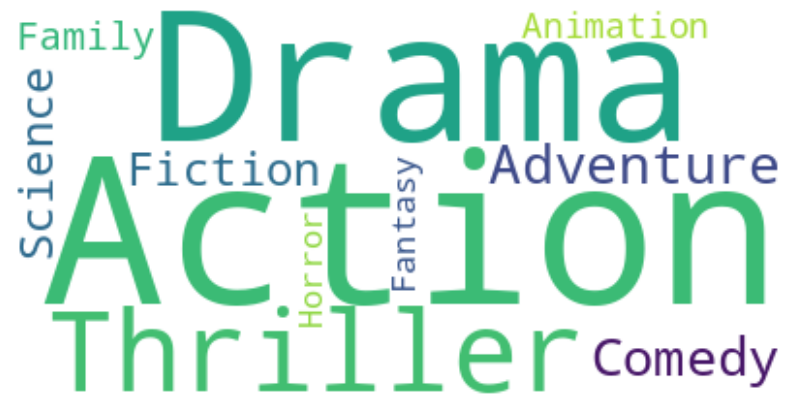

In [171]:
# 1. Nube de generos mas relevantes


text1 = ' '.join(df_exploded['genres'].dropna())

# Creo una nube de palabras
word_cloud2 = WordCloud(collocations = False, background_color = 'white').generate(text1)

# muestro la nube de palabras
plt.figure(figsize = (10,10))
plt.imshow(word_cloud2, interpolation='bilinear')

plt.axis("off")

plt.show()

In [172]:
# Estilo visual
# sns.set(style="whitegrid")

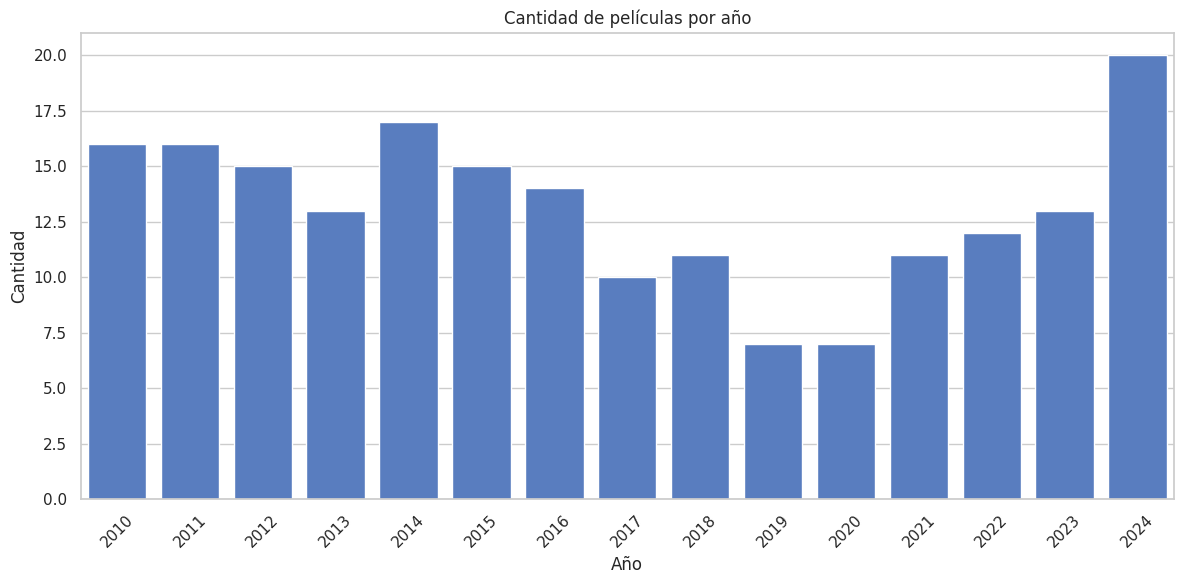

In [173]:
# 2. Películas por año
plt.figure(figsize=(12,6))
sns.countplot(data=df_clean, x='year', order=sorted(df_clean['year'].unique()))
plt.xticks(rotation=45)
plt.title('Cantidad de películas por año')
plt.xlabel('Año')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.show()

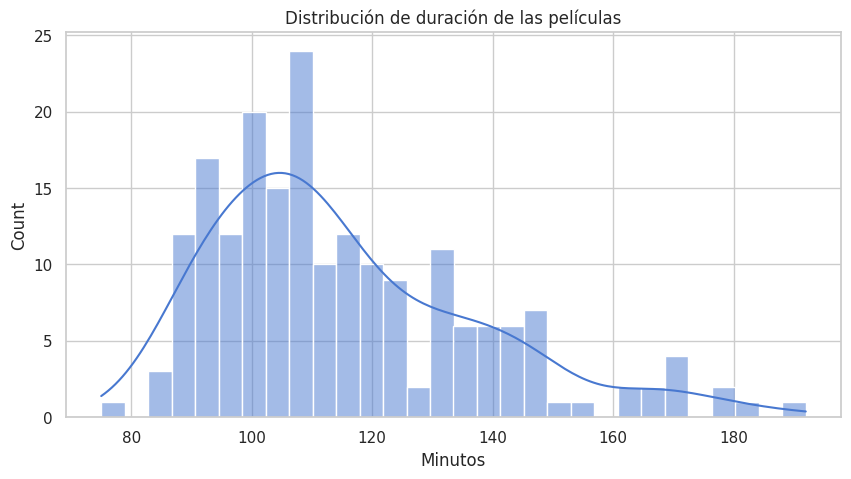

In [174]:
# 3. Distribución de duración (runtime)
plt.figure(figsize=(10,5))
sns.histplot(df_clean['runtime'], bins=30, kde=True)
plt.title('Distribución de duración de las películas')
plt.xlabel('Minutos')
plt.show()

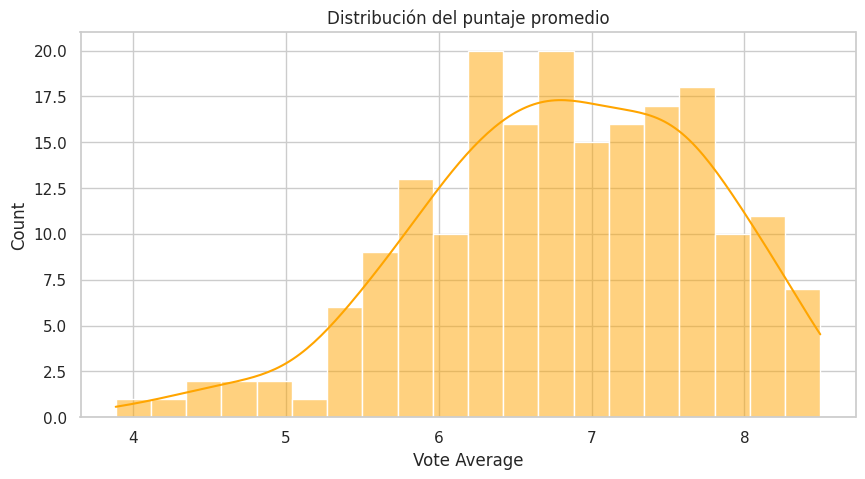

In [175]:
# 4. Distribución de calificaciones
plt.figure(figsize=(10,5))
sns.histplot(df_clean['vote_average'], bins=20, kde=True, color='orange')
plt.title('Distribución del puntaje promedio')
plt.xlabel('Vote Average')
plt.show()

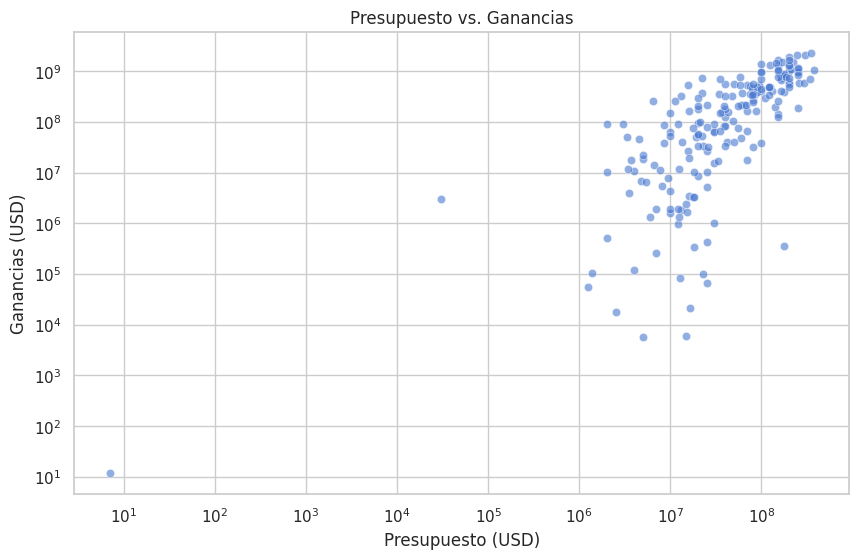

In [176]:
# 5. Presupuesto vs ganancia
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_clean, x='budget', y='revenue', alpha=0.6)
plt.title('Presupuesto vs. Ganancias')
plt.xlabel('Presupuesto (USD)')
plt.ylabel('Ganancias (USD)')
plt.xscale('log')
plt.yscale('log')
plt.show()

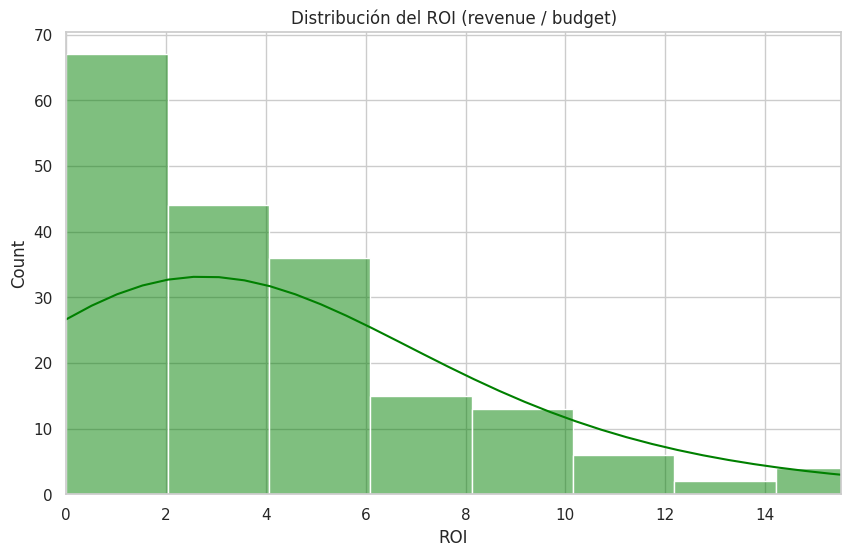

In [177]:
# 6. Retorno de la inversión
plt.figure(figsize=(10,6))
sns.histplot(df_clean['roi'], bins=50, kde=True, color='green')
plt.title('Distribución del ROI (revenue / budget)')
plt.xlabel('ROI')
plt.xlim(0, df_clean['roi'].quantile(0.95))  # recortar outliers extremos
plt.show()

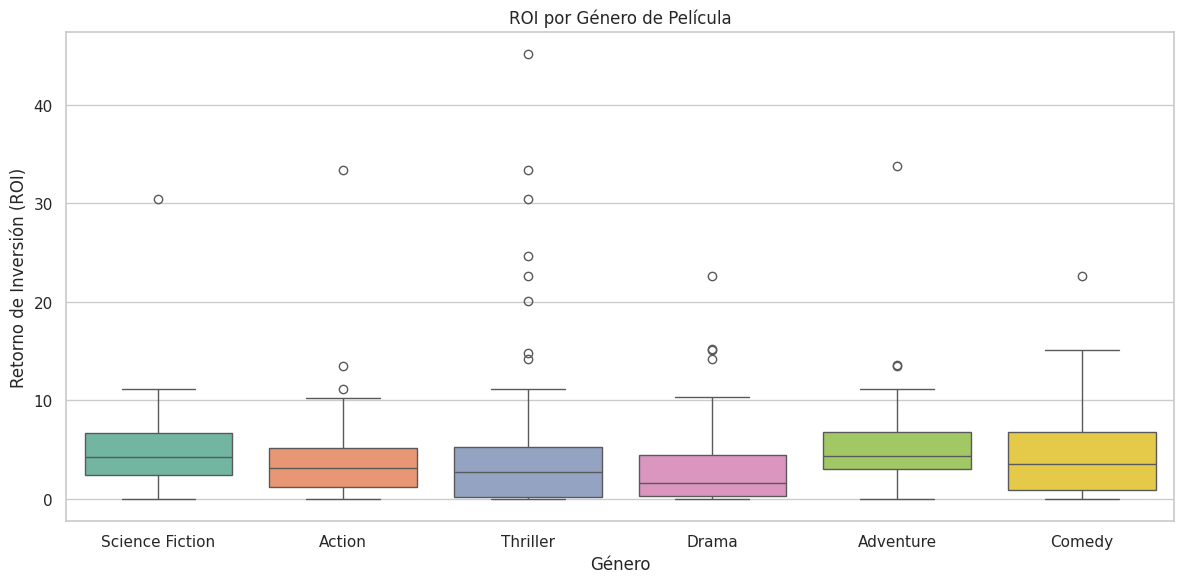

In [178]:
# 7. boxplot de ROI del top de peliculas mas comunes

plt.figure(figsize=(12,6))

# se define un top 6 a fines practicos
top_genres = df_exploded['genres'].value_counts().head(6).index
df_top = df_exploded[df_exploded['genres'].isin(top_genres)]

# Boxplot
sns.boxplot(data=df_top, x='genres', y='roi', hue='genres',  palette='Set2',  legend=False )

plt.title('ROI por Género de Película')
plt.xlabel('Género')
plt.ylabel('Retorno de Inversión (ROI)')

plt.tight_layout()
plt.show()

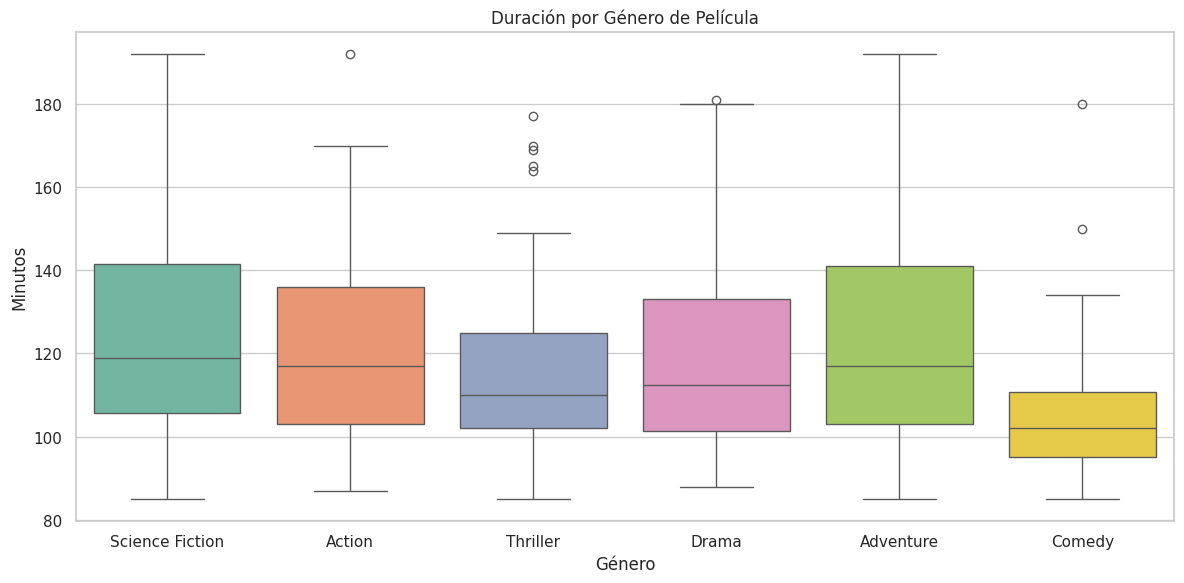

In [179]:
# 8. boxplot de Duracion del top de peliculas mas destacadas

plt.figure(figsize=(12,6))

sns.boxplot(data=df_top, x='genres', y='runtime', hue='genres',  palette='Set2',  legend=False  )

plt.title('Duración por Género de Película')
plt.xlabel('Género')
plt.ylabel('Minutos')

plt.tight_layout()
plt.show()

In [180]:
# 9. Peliculas con mayor ROI
top_roi = df_clean.sort_values(by='roi', ascending=False).head(10)
print(top_roi[['title', 'budget', 'revenue', 'roi']])

                                                 title    budget    revenue  \
26                                             Catfish     30000    3045943   
587                                        Terrifier 3   2000000   90322103   
165                                          Annabelle   6500000  257589952   
365                                             Ne Zha  22000000  742718496   
424  Demon Slayer -Kimetsu no Yaiba- The Movie: Mug...  15700000  523542183   
141                                          The Purge   3000000   91266581   
148                                      The Conjuring  13000000  320422209   
370                                           Parasite  11363000  257591776   
281                                                 It  35000000  704242888   
349                                            The Nun  22000000  366082797   

            roi  
26   101.531433  
587   45.161051  
165   39.629223  
365   33.759932  
424   33.346636  
141   30.422194  
148 

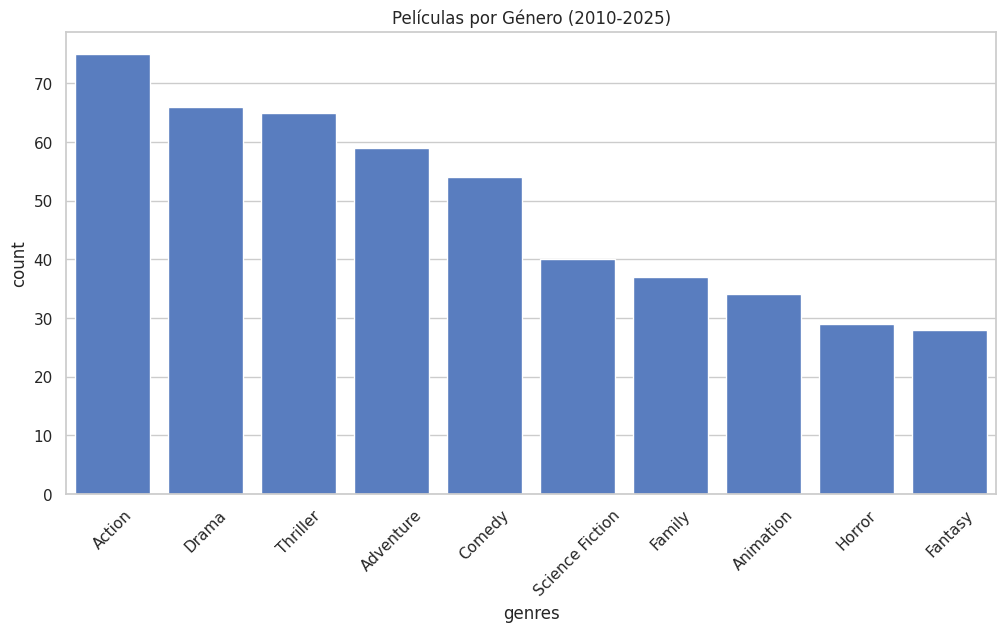

In [181]:
# 10. Peliculas por genero

plt.figure(figsize=(12,6))
sns.countplot(data=df_exploded, x='genres', order=df_exploded['genres'].value_counts().index[:10])
plt.title("Películas por Género (2010-2025)")
plt.xticks(rotation=45)
plt.show()

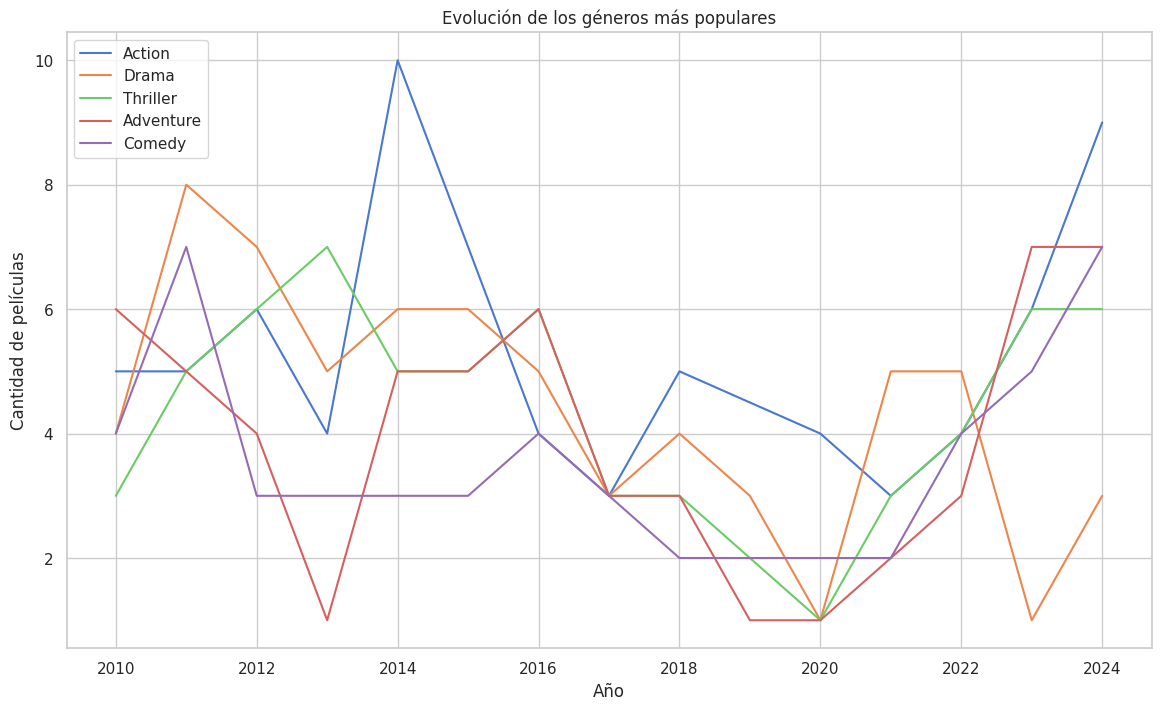

In [182]:
# 11. Tendencias de popularidad
genre_year = df_exploded.groupby(['year', 'genres']).size().reset_index(name='count')

plt.figure(figsize=(14,8))
top_genres = df_exploded['genres'].value_counts().index[:5]

for genre in top_genres:
    data = genre_year[genre_year['genres'] == genre]
    plt.plot(data['year'], data['count'], label=genre)

plt.legend()
plt.title('Evolución de los géneros más populares')
plt.xlabel('Año')
plt.ylabel('Cantidad de películas')
plt.grid(True)
plt.show()

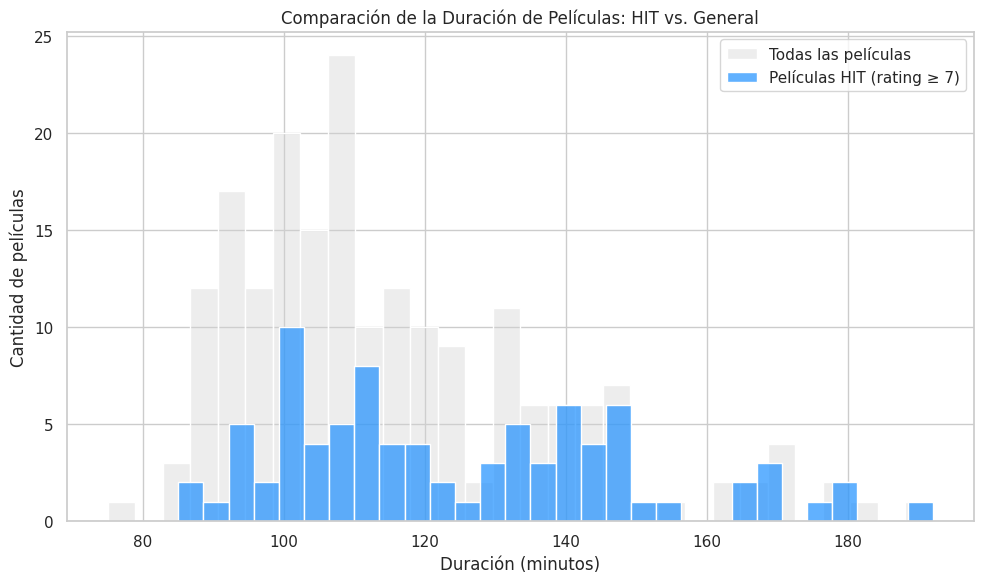

In [183]:
plt.figure(figsize=(10,6))

sns.histplot(
    data=df_clean,
    x='runtime',
    bins=30,
    color='lightgray',
    label='Todas las películas',
    alpha=0.4
)

sns.histplot(
    data=df_clean[df_clean['is_hit'] == True],
    x='runtime',
    bins=30,
    color='dodgerblue',
    label='Películas HIT (rating ≥ 7)',
    alpha=0.7
)

plt.title('Comparación de la Duración de Películas: HIT vs. General')
plt.xlabel('Duración (minutos)')
plt.ylabel('Cantidad de películas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


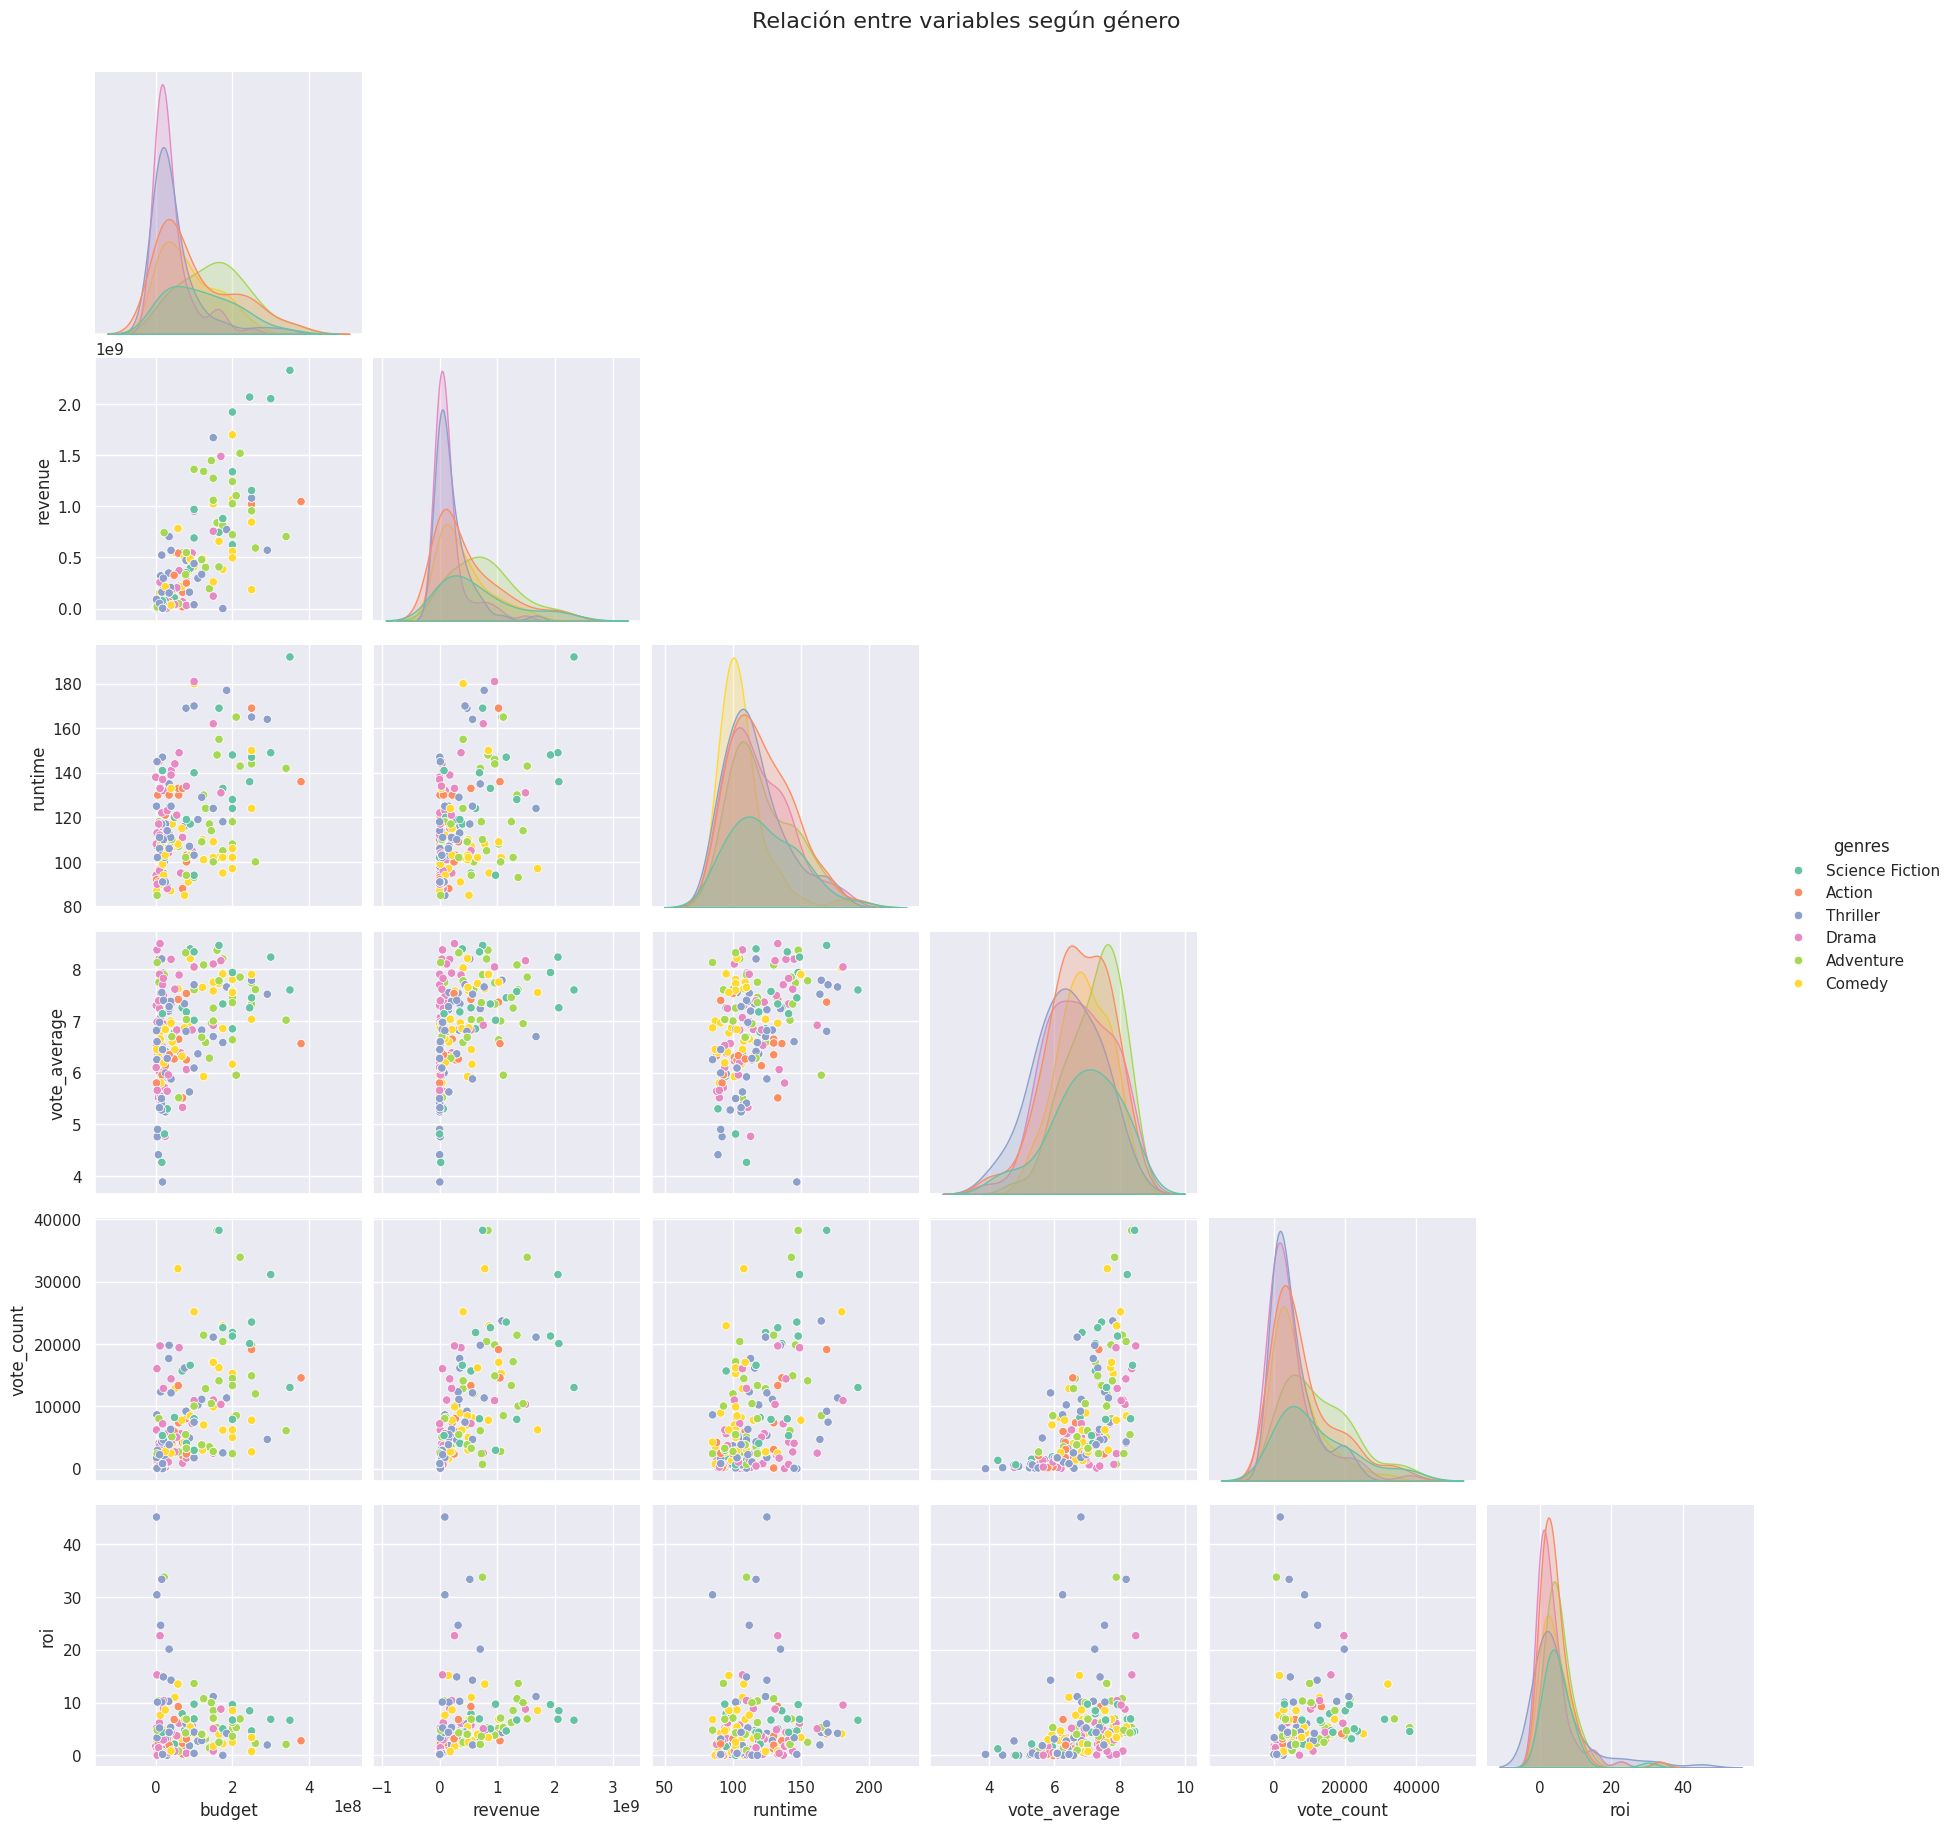

In [184]:
# Macro analisis

# Analisis de variables cuantitativas continuas
cols = ['budget', 'revenue', 'runtime', 'vote_average', 'vote_count', 'roi', 'genres']

# pairplot
sns.set(font_scale=1)
sns.pairplot(
    df_top[cols],
    hue="genres",
    height=3,
    corner=True,  # solo la mitad inferior del gráfico
    palette="Set2"
)
plt.suptitle("Relación entre variables según género", fontsize=16, y=1.02)
plt.show()


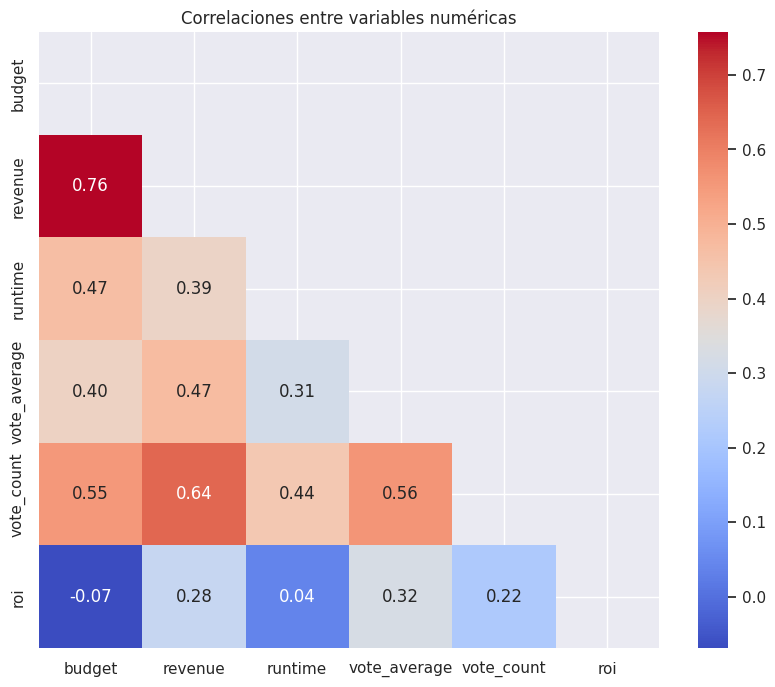

In [185]:
# Diagrama de correlación pearson
plt.figure(figsize=(10,8))
mask = np.triu(np.ones_like(df_exploded[['budget', 'revenue', 'runtime', 'vote_average', 'vote_count', 'roi']].corr()
,dtype=bool))
sns.heatmap(df_exploded[['budget', 'revenue', 'runtime', 'vote_average', 'vote_count', 'roi']].corr(),mask=mask,fmt=".2f", annot=True, cmap='coolwarm')
plt.title('Correlaciones entre variables numéricas')
plt.show()

# **Algunas conclusiones generales:**

* La rentabilidad (ROI) no depende linealmente del presupuesto.
* Terror y comedia muestran una relación favorable entre inversión y ganancia.
* las peliculas que mejor destacan en ROI y puntaje son de terror (insidiuos, terrifier y get out)
* La mayoría de las películas exitosas (ROI > 2) duran entre 90 y 120 minutos.
* La producción de películas ha disminuido entre 2010 y 2024, especialmente post pandemia



# **Ingeniería de atributo:**

Comenzamos a generar las modificaciones necesarias para preparar el modelo

El modelo que queremos realizar es para ayudarnos a definir cuando una pelicula va a ser exitosa

In [186]:
# 1. Definición de variable objetivo (is_hit mide si es exitoso <7)
y = df["is_hit"]

# 2. Features (evitar data leakage)
X = df[[ "budget", "runtime", "popularity", "year", "is_english", "genres" ]].copy()

# 2.1. Convertir booleans a int para el caso de is_englihs
X["is_english"] = X["is_english"].astype(int)


# 3. Codificación de géneros para volverlos ajustables al modelo
df["genres"] = df["genres"].apply(lambda x: x if isinstance(x, list) else x.split(", "))

mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(df["genres"])
genres_df = pd.DataFrame(genres_encoded,
                         columns=mlb.classes_,
                         index=df.index)

X = pd.concat([X.drop(columns=["genres"]), genres_df], axis=1)

# 4. Escalado de columnas numericas
num_cols = ["budget", "runtime", "popularity", "year"]

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# 5. Comenza el Train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5.1. Validación de Modelos base
# -----------------------------
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(eval_metric="logloss", random_state=42)

# Validación cruzada (5 folds)
rf_auc = cross_val_score(rf, X_train, y_train, cv=5, scoring="roc_auc").mean()
xgb_auc = cross_val_score(xgb, X_train, y_train, cv=5, scoring="roc_auc").mean()

print(f"🔹 Random Forest AUC promedio: {rf_auc:.4f}")
print(f"🔹 XGBoost AUC promedio:      {xgb_auc:.4f}")

# Selección automática del mejor modelo base
if xgb_auc > rf_auc:
    base_model_name = "XGBoost"
    base_model = xgb
else:
    base_model_name = "Random Forest"
    base_model = rf

print(f"\n⭐ El mejor modelo base es: {base_model_name}\n")

🔹 Random Forest AUC promedio: 0.7700
🔹 XGBoost AUC promedio:      0.7290

⭐ El mejor modelo base es: Random Forest



#**Pasamos a la optimización del modelo escogido (random forest)**

Seguimos con RandomizedSearchCV

In [187]:
# Optimización del Mejor Modelo Base — RandomizedSearchCV
print(f"Iniciando optimización del modelo: {base_model_name}")

# Definición de Hiperparámetros para Random Forest
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("\n🔹 Mejores parámetros encontrados:")
print(random_search.best_params_)
print(f"🔹 Mejor ROC-AUC en Validación: {random_search.best_score_:.4f}")

best_model = random_search.best_estimator_


Iniciando optimización del modelo: Random Forest
Fitting 3 folds for each of 20 candidates, totalling 60 fits

🔹 Mejores parámetros encontrados:
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 5}
🔹 Mejor ROC-AUC en Validación: 0.7973


Continuamos con la evaluación del modelo optimizado


📊 Classification Report:
              precision    recall  f1-score   support

       False       0.80      0.70      0.74        23
        True       0.65      0.76      0.70        17

    accuracy                           0.72        40
   macro avg       0.73      0.73      0.72        40
weighted avg       0.74      0.72      0.73        40

🔹 AUC en Test: 0.8210



<Figure size 600x400 with 0 Axes>

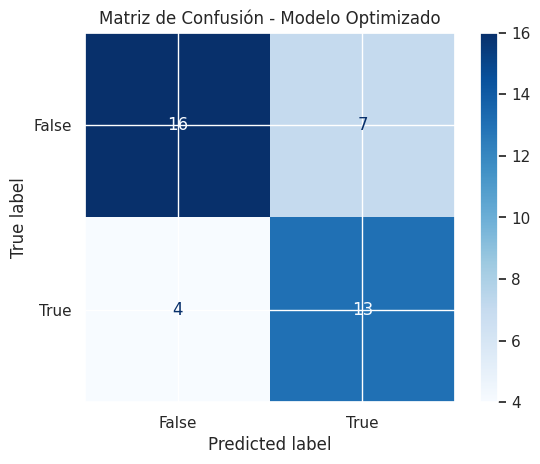

<Figure size 600x400 with 0 Axes>

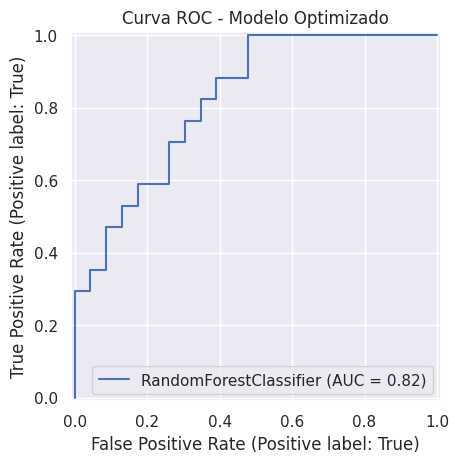

In [188]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Reporte de metricas
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

test_auc = roc_auc_score(y_test, y_proba)
print(f"🔹 AUC en Test: {test_auc:.4f}\n")

# Matriz de Confusion
plt.figure(figsize=(6,4))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap="Blues")
plt.title("Matriz de Confusión - Modelo Optimizado")
plt.show()

# Generación de curca ROC
plt.figure(figsize=(6,4))
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("Curva ROC - Modelo Optimizado")
plt.show()


Aunque se ve un buen performance, a nivel negocio, se requiere mejorar el recall de los true (0,76) sin impactar en el AUC y Precission

De esa forma, tomamos más casos que pueden ser hits

Continuamos con una curva para comparar y establecer cual es el mejor threshold a tomar

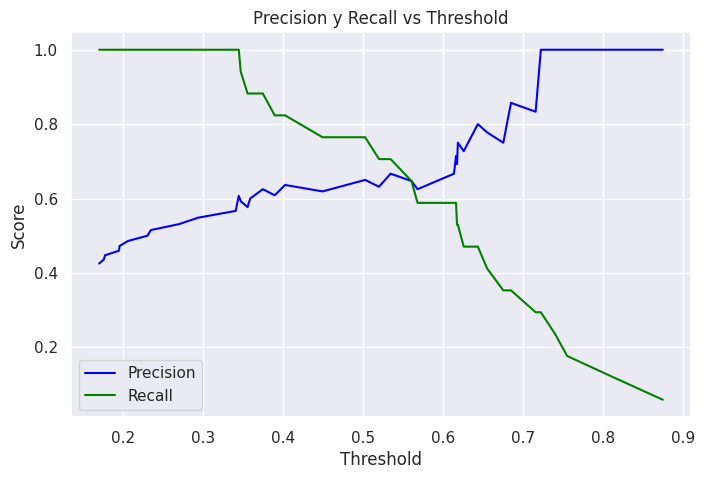

In [189]:
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8,5))
plt.plot(thresholds_pr, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds_pr, recall[:-1], label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision y Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


Tomo la decisión de ir con un t=0,45 para mejorar el recall y darle oportunidad a más peliculas que pueden ser exitosas

In [194]:
# Entrenar modelo base en todo el set de entrenamiento
base_model.fit(X_train, y_train)

# Probabilidades de la clase True
y_proba = base_model.predict_proba(X_test)[:, 1]

# Aplicar threshold 0.45
threshold = 0.45
y_pred_adjusted = (y_proba >= threshold).astype(int)

# generamos el report del modelo optimizado
print("🔹 Classification Report con threshold=0.45:\n")
print(classification_report(y_test, y_pred_adjusted))
print(f"🔹 AUC en Test: {roc_auc_score(y_test, y_proba):.4f}")

🔹 Classification Report con threshold=0.45:

              precision    recall  f1-score   support

       False       0.82      0.61      0.70        23
        True       0.61      0.82      0.70        17

    accuracy                           0.70        40
   macro avg       0.72      0.72      0.70        40
weighted avg       0.73      0.70      0.70        40

🔹 AUC en Test: 0.8005


** Observación importante:**
El ajuste a 0.45 aumenta el recall de la clase positiva (True) y reduce recall de la clase negativa. Esto hace sentido porque la prioridad es capturar más hits, aunque se sacrifique un poco de precisión en False.

En base a eso, vamos a seguir optimizando los hiperparametros ahora con este threshold

In [192]:
# 1. Definir espacio de hiperparámetros
param_dist = {
    "n_estimators": randint(50, 500),       # Número de árboles
    "max_depth": randint(3, 20),            # Profundidad máxima
    "min_samples_split": randint(2, 10),    # Mínimo de muestras para dividir
    "min_samples_leaf": randint(1, 10),     # Mínimo de muestras en hoja
    "max_features": ["auto", "sqrt", "log2", None]  # Número de features a considerar
}

# 2. Configurar RandomizedSearchCV
rf_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=50,               # número de combinaciones a probar
    scoring="roc_auc",       # optimizamos AUC
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# 3. Entrenar búsqueda
rf_search.fit(X_train, y_train)

# Mejor modelo
best_rf = rf_search.best_estimator_
print("⭐ Mejores hiperparámetros encontrados:")
print(rf_search.best_params_)

# 4. Evaluación final con threshold 0.45
# Probabilidades
y_proba = best_rf.predict_proba(X_test)[:, 1]

# Aplicar threshold
y_pred_thresh = (y_proba >= 0.45).astype(int)

# Reporte
print("\n🔹 Classification Report con threshold=0.45:")
print(classification_report(y_test, y_pred_thresh))

# AUC
auc_final = roc_auc_score(y_test, y_proba)
print(f"🔹 AUC en Test: {auc_final:.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
50 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/

⭐ Mejores hiperparámetros encontrados:
{'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 3, 'n_estimators': 436}

🔹 Classification Report con threshold=0.45:
              precision    recall  f1-score   support

       False       0.84      0.70      0.76        23
        True       0.67      0.82      0.74        17

    accuracy                           0.75        40
   macro avg       0.75      0.76      0.75        40
weighted avg       0.77      0.75      0.75        40

🔹 AUC en Test: 0.7877


# **Conclusiones**

En base al uso del modelo de random forest optimizado, se logra predecir si una pelicula puede ser un exito (is_hit) con un desempeño aceptable

El accuracy no se ve tan afectado y está dentro de un rango bueno (0,75), F1-Score promedio de 0,75 y AUC de 0,7877

A mi pensar, el modelo es robusto, y fue una buena decisión haberlo ajustado a 0,45 para balancear la sensibilidad y precisión, y lograr detectar mas peliculas que pueden tener exito

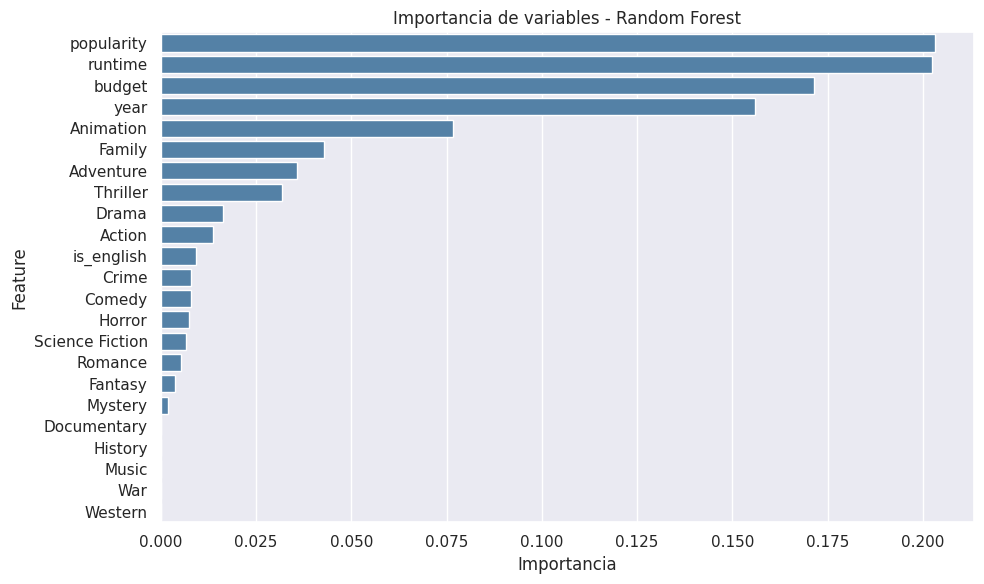

In [193]:
# Obtener importancia de features
feature_importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": best_rf.feature_importances_
}).sort_values(by="importance", ascending=False)

# Gráfico
plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=feature_importances, color="steelblue")
plt.title("Importancia de variables - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()




# **Recomendaciones para negocio**

Variables que más impactan el éxito (Random Forest):

* Presupuesto (budget) → Películas con mayor inversión tienden a tener más chance de éxito.

* Popularidad (popularity) → Indicador directo de interés anticipado del público.

* Duración (runtime) → Duraciones medianas tienden a tener mejores resultados.

* Géneros → Algunos géneros como acción, aventura o animación muestran mayor correlación con éxito.

* Año de lanzamiento (year) → Estrategias de lanzamiento recientes influyen en la performance.

Recomendación práctica: Priorizar proyectos con mayor presupuesto y popularidad
esperada, considerando géneros que históricamente tienen más éxito. Ajustar estrategias de marketing según estas variables para maximizar ROI.